In [2]:
import skimage.io
import numpy as np
from skimage import exposure
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def plot_visualization(gray_contrast, gt_per, mrcnn_per, mrcnn_xor, watershed_per, watershed_xor, dimensions, figure_name,
                      kaggle_per = None, kaggle_xor = None, mag = 1):
    """
    Generates the plots for a given FOV and inference results
    
    Arguments: 
        gray_contrast: 2D numpy array
            The gray image
        
        gt_per: 2D numpy array (uint16)
            The ground truth labels
            
        mrcnn_per: 2D numpy array (uint16)
            The inference from the MRCNN 
            
        mrcnn_xor: 2D numpy array 
            The different in pixels between ground truth and mrcnn inference
        
        watershed_per: 2D numpy array
            The inference from the FPN-watershed
            
        watershed_xor: 2D numpy 
            The different in pixels between ground truth and FPN-watershed inference
        
        dimension: tuple(4)
            The ROI indexes from the FOV to display
        
        figgure_name: string
            The file name to save the figure
            
        kaggle_per: 2Dnum,py array (uint 16)
            The inference from Jackobie (Kaggle 2018 data science bowl)
            
        mag: float
            The magnification of the cell lines
    
    """

        
    nfigures = 5
    if kaggle_per is not None: 
        nfigures += 1
    
    if kaggle_xor is not None: 
        nfigures += 1

    dim = dimensions
    
    fig, axes = plt.subplots(1,nfigures, figsize=(32,32))
    fig.tight_layout(pad=-2.6)


    #nuclei_cmap = "nipy_spectral"
    #inf_alpha = 0.5
    #err_alpha = 0.3
    
    nuclei_cmap = "gist_ncar"
    inf_alpha = 0.7
    err_alpha = 0.5
    
    #convert zero to black color in gitst_ncar
    if nuclei_cmap == "gist_ncar":
        from matplotlib import cm
        from matplotlib.colors import ListedColormap
        gist_ncar = cm.get_cmap('gist_ncar', 256)
        newcolors = gist_ncar(np.linspace(0, 1, 256))
        black = np.array([0, 0, 0, 1])
        magneta = np.array([1, 0, 1, 1])
        newcolors[0, :] = black
        newcolors[255, :] = magneta
        newcmp = ListedColormap(newcolors)
        nuclei_cmap = newcmp
    
    print("mrcnn:", np.max(mrcnn_xor))
    print("watershed:", np.max(watershed_xor))
    print("Kaggle:", np.max(kaggle_xor))
    
    axes_id = -1

    axes_id += 1
    axes[axes_id].imshow(gt_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(mrcnn_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(watershed_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)
    
    if kaggle_per is not None:
        axes_id += 1
        axes[axes_id].imshow(kaggle_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
        axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(mrcnn_xor[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= err_alpha)

    axes_id += 1
    axes[axes_id].imshow(watershed_xor[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= err_alpha)

    if kaggle_xor is not None:
        axes_id += 1
        axes[axes_id].imshow(kaggle_xor[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
        axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= err_alpha)
    

    x_loc = int((dim[1] - dim[0]) * 3 / 4)
    y_loc = int((dim[3] - dim[2]) * 7 / 8)
    
    lower_write = dim[1] - dim[0] - 20 / (500 / (dim[1] - dim[0]))
    rect = patches.Rectangle((lower_write - mag, y_loc), mag, 8, color ='w')
    axes[axes_id].add_patch(rect)

    
    
    #Turn off axis and y axis
    for axes_id in range(0, nfigures):
        axes[axes_id].get_xaxis().set_visible(False)
        axes[axes_id].get_yaxis().set_visible(False)

    fig.savefig(figure_name, bbox_inches = 'tight',pad_inches = 0)

In [32]:
def generate_error_visualization(exp, fov, dimensions, mag):
    
    """
    Generates the plots for a biological experiment
    
    Arguments:
        exp: string
            The name of the biological experiment directory
        
        fov: string
            The tif file for the fov
            
        mag: float
            The magnification of the experiment.
    """
    
    #gt_mode can be either GT, GT-manual
    #GT is semi automatic/faster, GT-manual is all manual
    gt_mode = "GT-manual"
    gt = os.path.join(img_dir, gt_mode, exp, fov)
    gray = os.path.join(img_dir, "GreyScale", exp, fov)
    mrcnn_run037 = os.path.join(img_dir, "Inference/MRCNN/Run37/mrcnn", exp, fov)
    mrcnn_run003 = os.path.join(img_dir, "Inference/MRCNN/Run03/mrcnn", exp, fov)
    fpn_w_run010 = os.path.join(img_dir, "Inference/UW2/Run10/watershed-2",exp, "images", fov)
    fpn_w_run004 = os.path.join(img_dir, "Inference/UW2/Run04/watershed-2", exp, "images", fov)
    kaggle = os.path.join(img_dir, "./Inference/MRCNN/Run44/kaggle-2nd", exp, fov)
    
    gt_img = skimage.io.imread(gt)
    gray_img = skimage.io.imread(gray)
    mrcnn_run037_img = skimage.io.imread(mrcnn_run037)
    mrcnn_run003_img = skimage.io.imread(mrcnn_run003)
    fpn_w_run010_img = skimage.io.imread(fpn_w_run010)
    fpn_w_run004_img = skimage.io.imread(fpn_w_run004)
    kaggle_img = skimage.io.imread(kaggle)
   

    #Increase the contrast of the gray scale image
    v_min, v_max = np.percentile(gray_img, (0.2, 99.8))
    gray_contrast = exposure.rescale_intensity(gray_img, in_range=(v_min, v_max))

    #fig 2: MRCNN run003, FPN run004
    print("GT images:")
    gt_per, gt_xor = get_images(gt_img,gt_img)
    mrcnn_per, mrcnn_xor = get_images(mrcnn_run003_img,gt_img)
    watershed_per, watershed_xor = get_images(fpn_w_run004_img,gt_img)
    print("Kaggle images:")
    kaggle_per, kaggle_xor = get_images(kaggle_img, gt_img)
    fig_name = "{0}_{1}_baseline.tif".format(exp, fov.replace(".tif", ""))
    plot_visualization(gray_contrast, gt_per, mrcnn_per, mrcnn_xor, watershed_per, watershed_xor, dimensions, fig_name, mag = mag)
    
    #fig 5: MRCNN run037, FPN run010
    
    print("MRCNN images:")
    mrcnn_per, mrcnn_xor = get_images(mrcnn_run037_img,gt_img)
    print("watershed images:")
    watershed_per, watershed_xor = get_images(fpn_w_run010_img,gt_img)
    
    fig_name = "{0}_{1}_all_images.tif".format(exp, fov.replace(".tif", ""))
    plot_visualization(gray_contrast, gt_per, mrcnn_per, mrcnn_xor, watershed_per, watershed_xor, dimensions, fig_name, 
                       kaggle_per = kaggle_per, 
                       kaggle_xor = kaggle_xor,
                      mag = mag)
    

In [71]:
def get_iou(inference, gt):
    """
    Retruns a 2D float for intersection of union ratio between ground truth and inference labes.
    
    Arguements:
        inference: 2D numpy array (uint16)
            The inference lables
        
        gt: 2D numpy array (uint16)
            The ground truth labels
            
    Returns: 2D numpy (float)
        The intersection of union ratio between all pairs of inference and ground truth labels.
    """
    true_objects = np.unique(gt)
    pred_objects = np.unique(inference)
    print("ground truth nuclei:", len(true_objects)-1)
    print("Inference nuclei:", len(pred_objects)-1)
    true_bins = np.append(true_objects, true_objects[-1] + 1)
    pred_bins = np.append(pred_objects, pred_objects[-1] + 1)
    intersection, xedges, yedges = np.histogram2d(gt.flatten(), inference.flatten(), bins=(true_bins, pred_bins))
    area_true = np.histogram(gt, bins = true_bins)[0]
    area_pred = np.histogram(inference, bins = pred_bins)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    return iou

In [92]:
def precision_at(threshold, iou):
    """
    Returns the count of true positive, false positives, false negatives at a given threshold
    for iou
    
    Arguments: 
        threshold: float
            The intersection over union threshold to consider a true positive prediction
        
        iou: 2D numpy (float)
            The intersection over union for all pair of ground truth and inference lables
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    matches_01 = iou > 0.1
    merges = np.sum(np.sum(matches_01, axis = 0) > 1)
    splits = np.sum(np.sum(matches_01, axis = 1) > 1)
    print("merges:{0}, splits:{1}, false_positives:{2}, false_negative:{3}".format(merges, splits, fp, fn))
    return true_positives, false_positives, false_negatives

In [37]:
def get_permuted_lookup(ids):
    """
    Returns a lookup table after permuting the Ids
    Arguments:
        ids: 2D numpy array 
            The 2D Ids array
    
    returns: 1D numpy array
        The permuted Ids
    """
    #Permute the instance ids for better display
    np.random.seed(2)
    max_id = np.max(ids)
    max_id = 2000
    lookup = np.random.permutation(max_id + 2)
    #Make sure background stays as background
    lookup = lookup[lookup != 0]
    lookup[0] = 0
    return lookup

In [38]:
def get_images(inference, gt):
    """
    Returns a permuted ids and errors highlights
    """
    iou = get_iou(inference, gt)
    tp, fp, fn = precision_at(0.7, iou)
    fn_indexes = np.nonzero(fn)[0] + 1
    fp_indexes = np.nonzero(fp)[0] + 1
    
    #Highlight false negative IDs from ground truth
    gt_fn = np.zeros(gt.shape)
    for nuclei_id in fn_indexes:
        gt_fn[gt == nuclei_id] = nuclei_id
        
    gt_xor_inference = np.bitwise_xor(gt != 0, inference != 0) * 2500
    lookup_gt = get_permuted_lookup(gt)
    gt_fn_permuted = lookup_gt[gt_fn.astype("uint16")]
    #highlight all the false positive nuclei in addition to xor
    np.copyto(gt_xor_inference, gt_fn_permuted, where = gt_fn != 0)
    
    lookup_inference = get_permuted_lookup(inference)
    inference_permuted = lookup_inference[inference]
    
    return [inference_permuted, gt_xor_inference]

In [39]:
GT_URL = 'https://ndownloader.figshare.com/files/22185189'
GS_URL = 'https://ndownloader.figshare.com/files/22185111'
INF_URL = 'https://ndownloader.figshare.com/files/22248840'


GT_PATH = 'GT.zip'
GS_PATH = 'Greyscale.zip'
INF_PATH = 'Inference.zip'

if not (os.path.isdir("GT") and os.path.isdir("Greyscale") and os.path.isdir("Inference")):
    from download_util import download_and_unzip_datasets
    download_and_unzip_datasets(GT_URL, GT_PATH)
    download_and_unzip_datasets(GS_URL, GS_PATH)
    download_and_unzip_datasets(INF_URL, INF_PATH)
    print("Downloading images")

GT images:
ground truth nuclei: 212
Inference nuclei: 212
merges:0, splits:0, false_positives:0, false_negative:0
ground truth nuclei: 212
Inference nuclei: 200
merges:18, splits:1, false_positives:27, false_negative:39
ground truth nuclei: 212
Inference nuclei: 210
merges:2, splits:0, false_positives:5, false_negative:7
Kaggle images:
ground truth nuclei: 212
Inference nuclei: 217
merges:1, splits:0, false_positives:7, false_negative:2
mrcnn: 2500
watershed: 2500
Kaggle: None
MRCNN images:
ground truth nuclei: 212
Inference nuclei: 221
merges:2, splits:0, false_positives:13, false_negative:4
watershed images:
ground truth nuclei: 212
Inference nuclei: 217
merges:0, splits:1, false_positives:7, false_negative:2
mrcnn: 2500
watershed: 2500
Kaggle: 2500


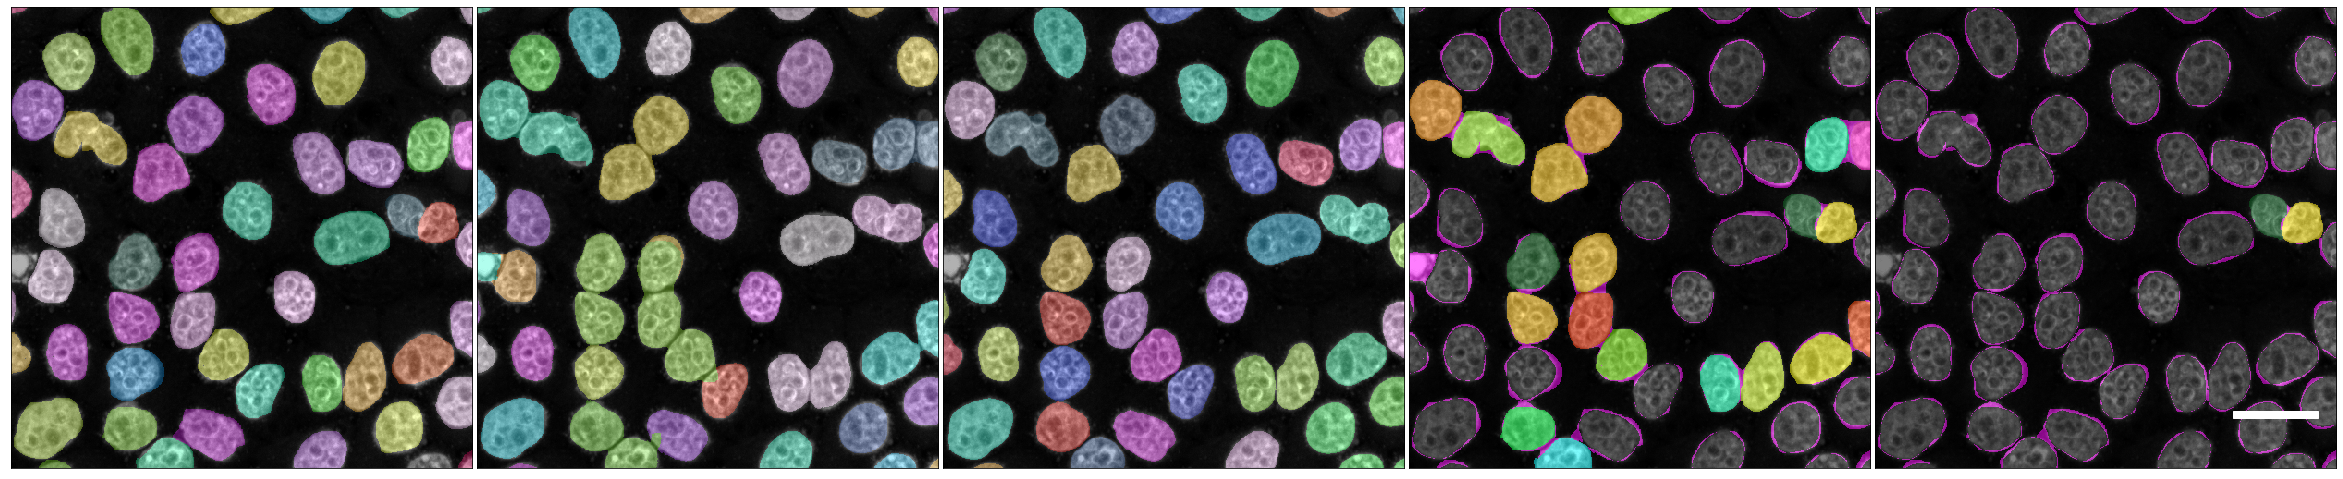

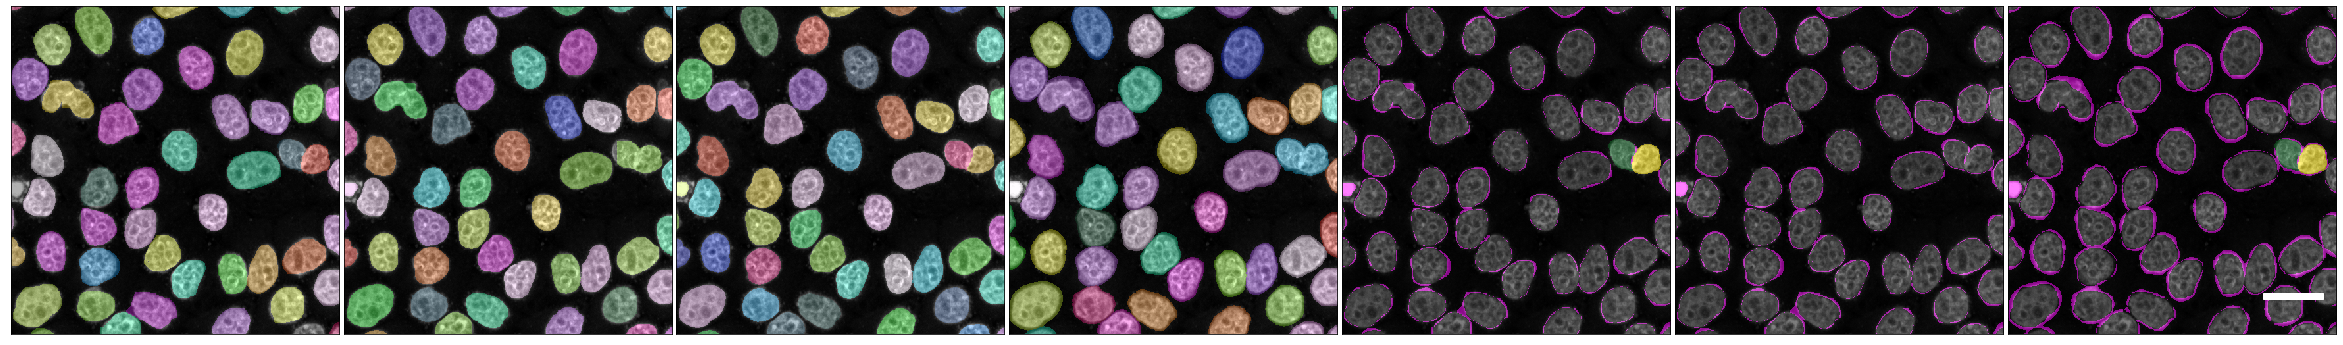

In [127]:
arg_dic = {}
img_dir = "."
exp_babe = "BABE_Biological"
fov_babe = "Plate1_E03_T0001FF001Zall.tif"
roi_babe = (500, 1000, 500, 1000)
mag_babe = int(20/0.216)

generate_error_visualization(exp_babe, fov_babe, roi_babe, mag_babe)

GT images:
ground truth nuclei: 212
Inference nuclei: 212
merges:0, splits:0, false_positives:0, false_negative:0
ground truth nuclei: 212
Inference nuclei: 200
merges:18, splits:1, false_positives:27, false_negative:39
ground truth nuclei: 212
Inference nuclei: 210
merges:2, splits:0, false_positives:5, false_negative:7
Kaggle images:
ground truth nuclei: 212
Inference nuclei: 217
merges:1, splits:0, false_positives:7, false_negative:2
mrcnn: 2500
watershed: 2500
Kaggle: None
MRCNN images:
ground truth nuclei: 212
Inference nuclei: 221
merges:2, splits:0, false_positives:13, false_negative:4
watershed images:
ground truth nuclei: 212
Inference nuclei: 217
merges:0, splits:1, false_positives:7, false_negative:2
mrcnn: 2500
watershed: 2500
Kaggle: 2500
GT images:
ground truth nuclei: 518
Inference nuclei: 518
merges:0, splits:0, false_positives:0, false_negative:0
ground truth nuclei: 518
Inference nuclei: 513
merges:31, splits:9, false_positives:69, false_negative:74
ground truth nucle

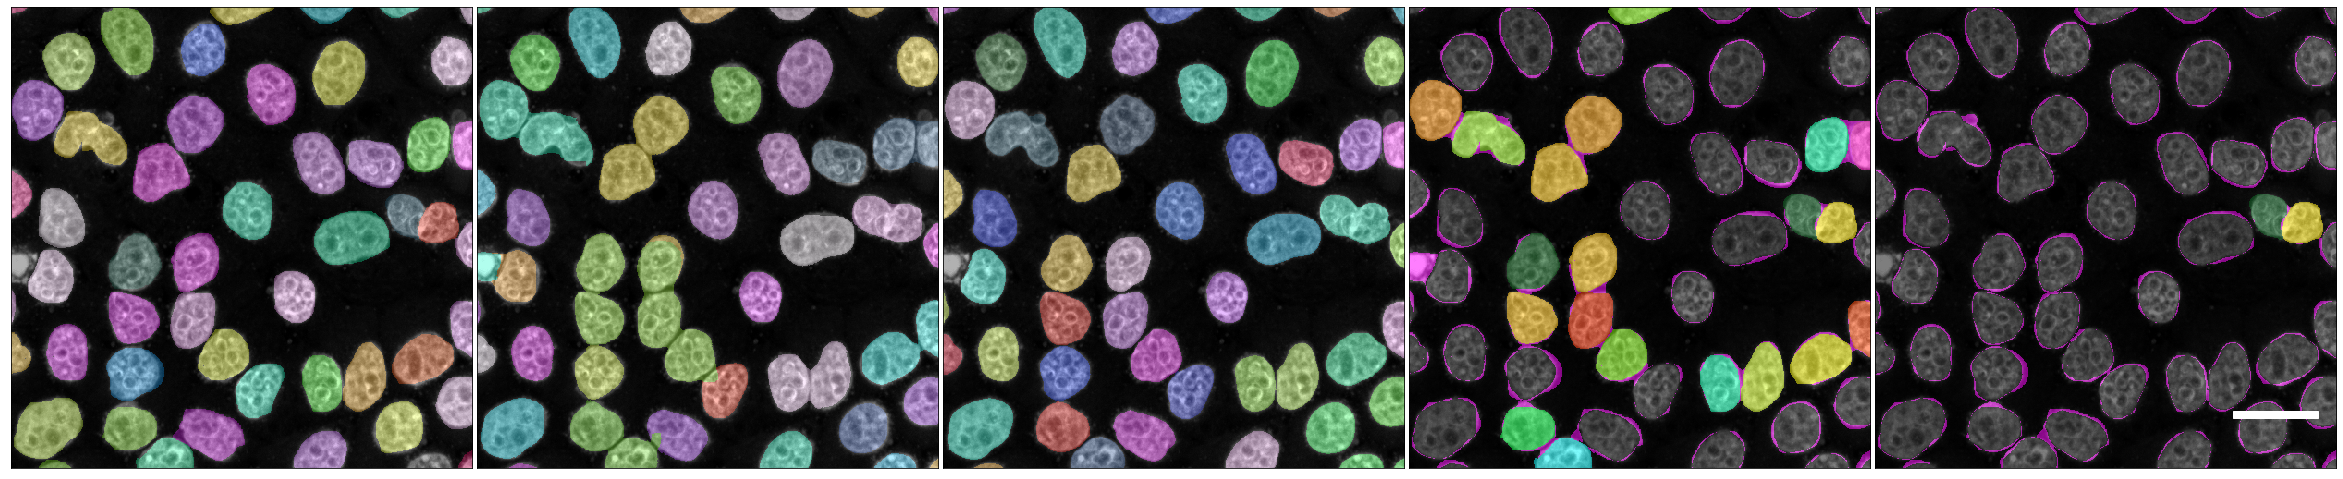

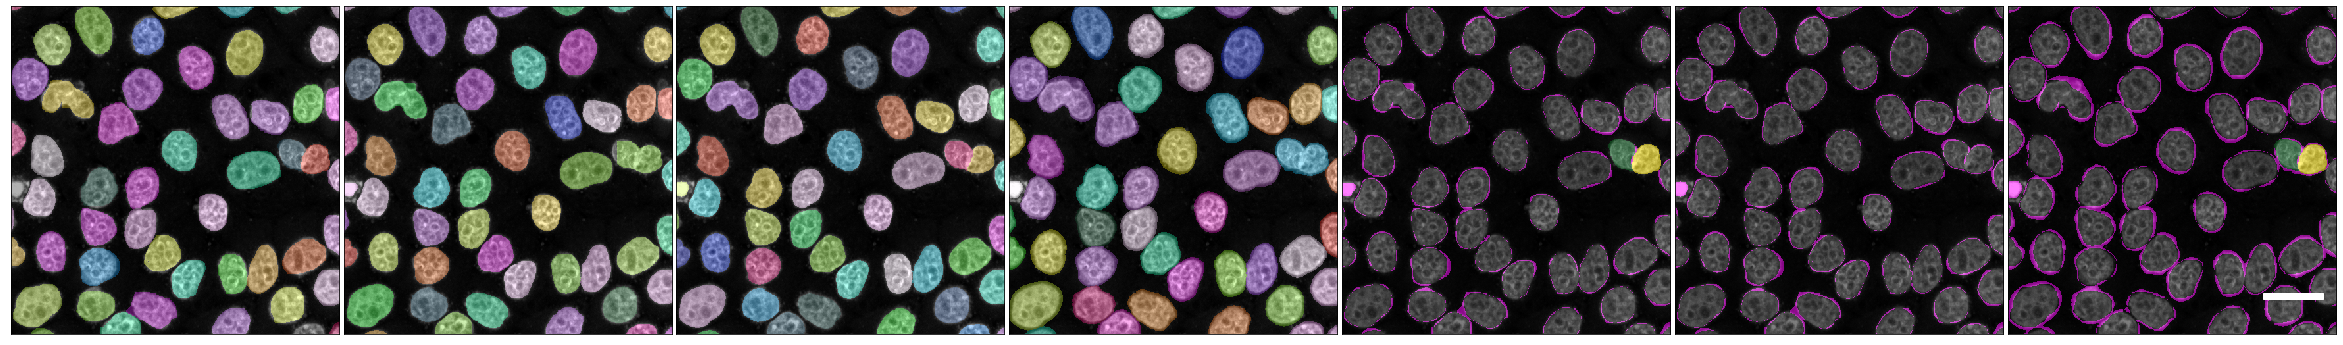

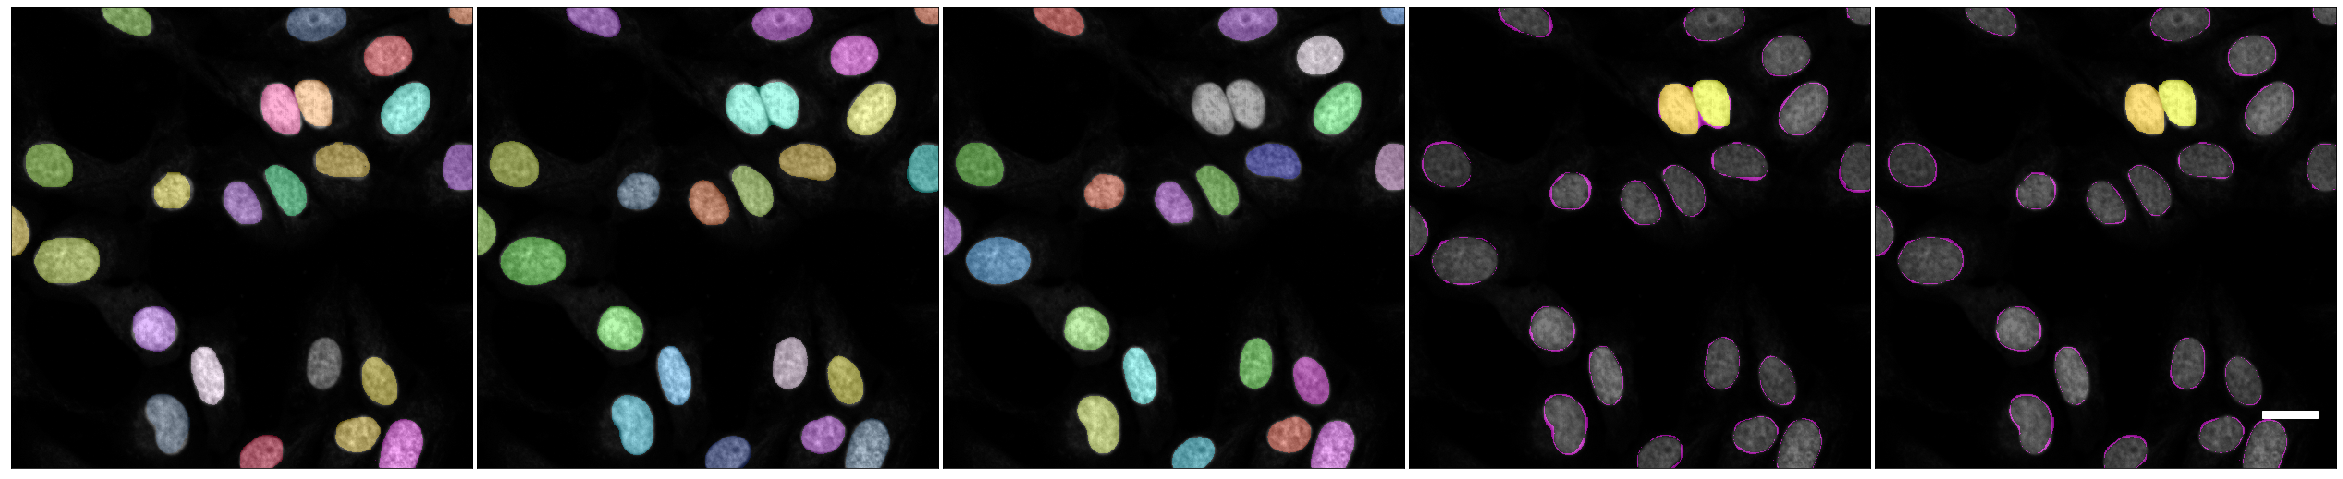

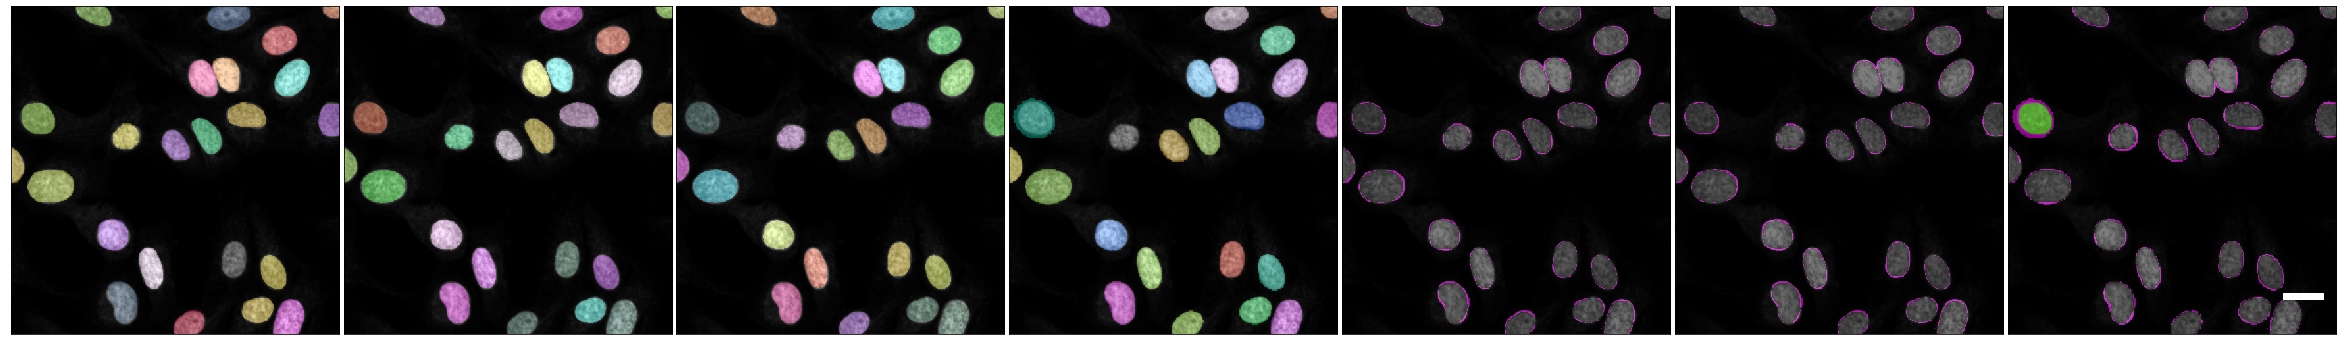

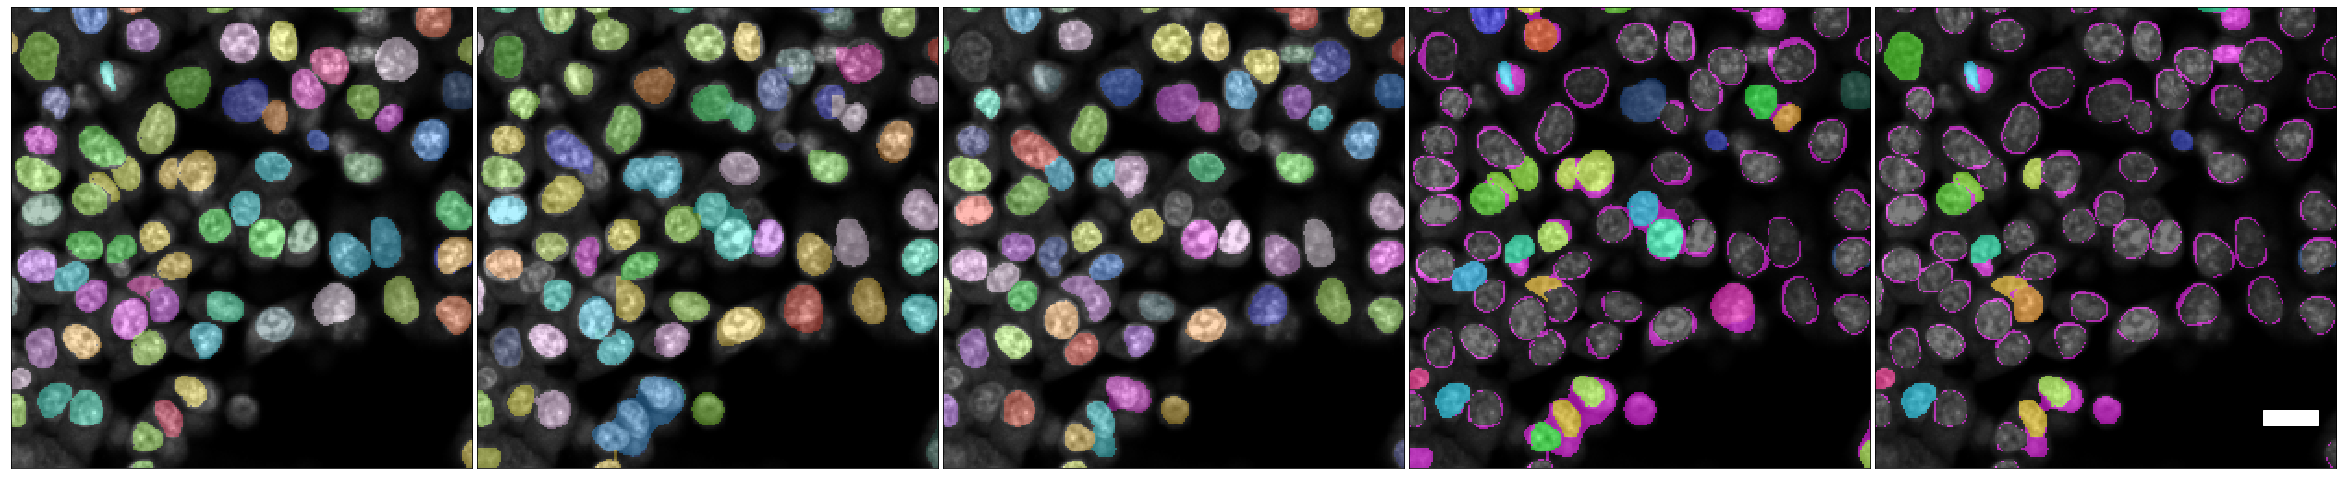

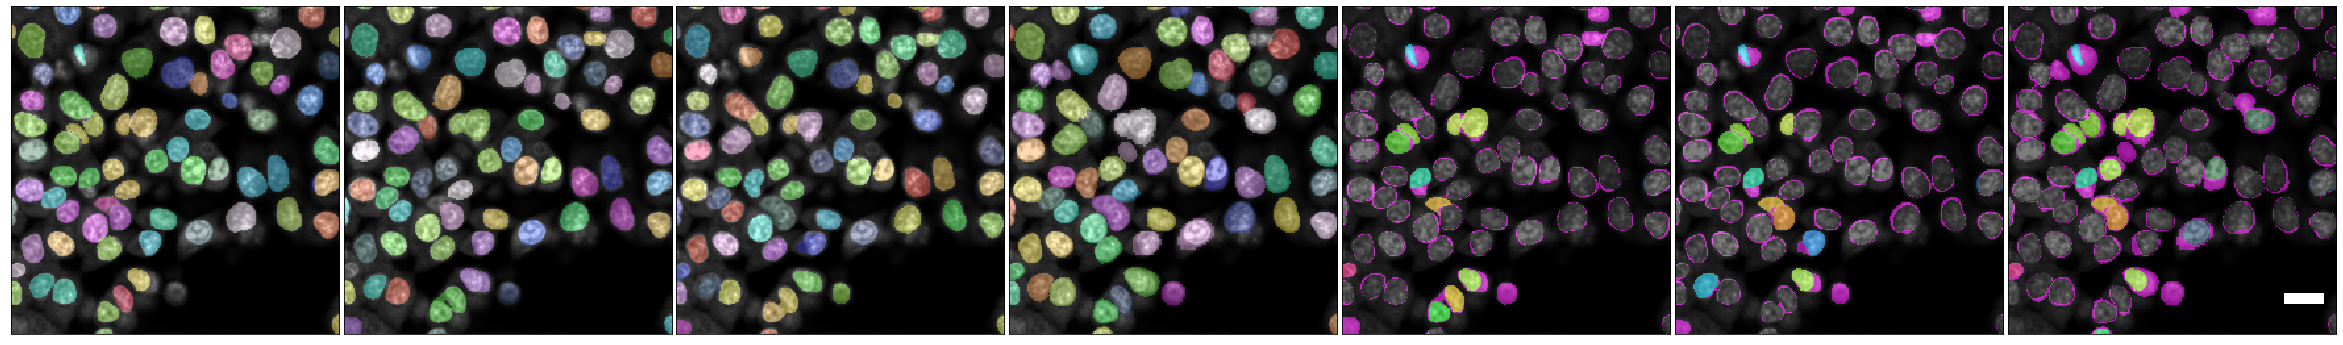

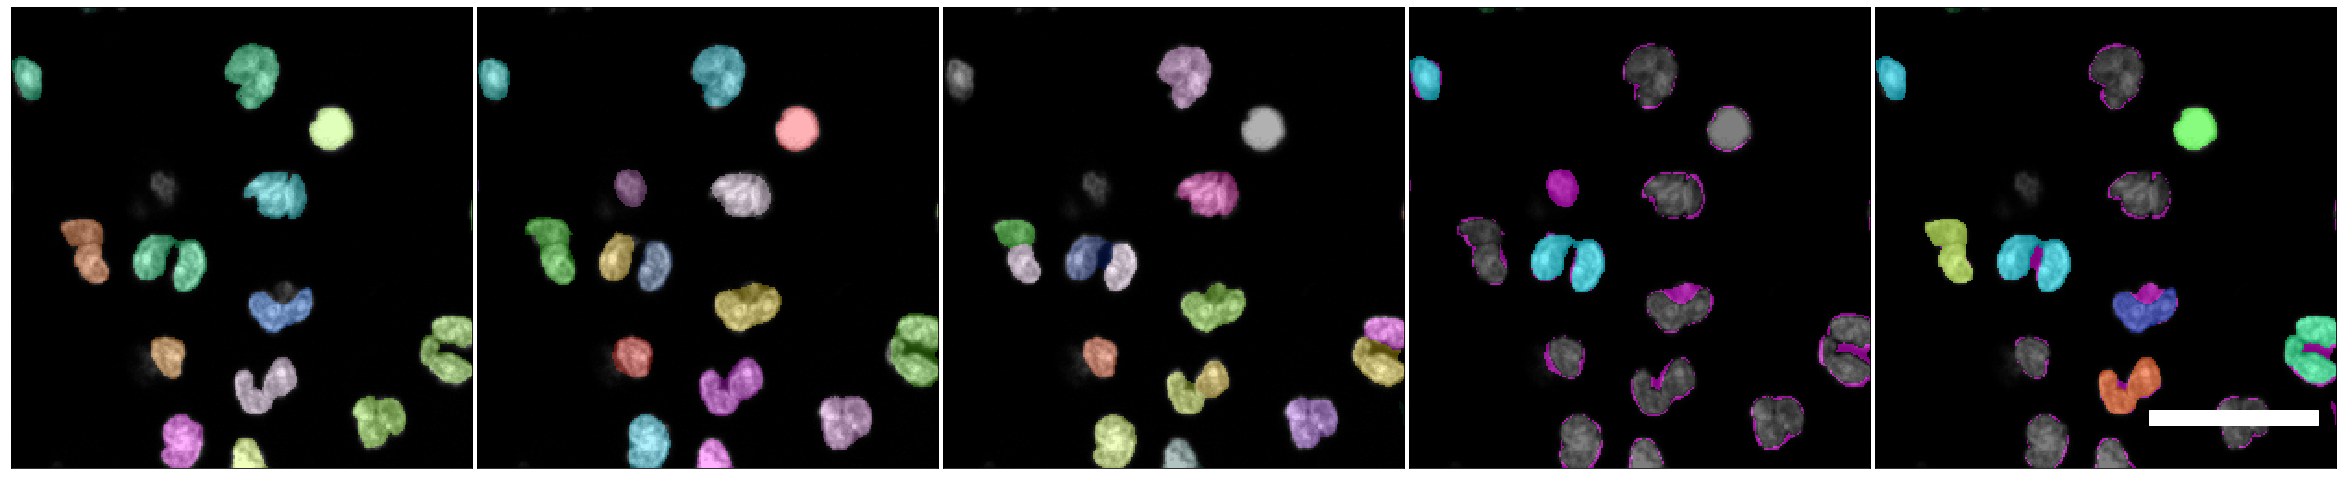

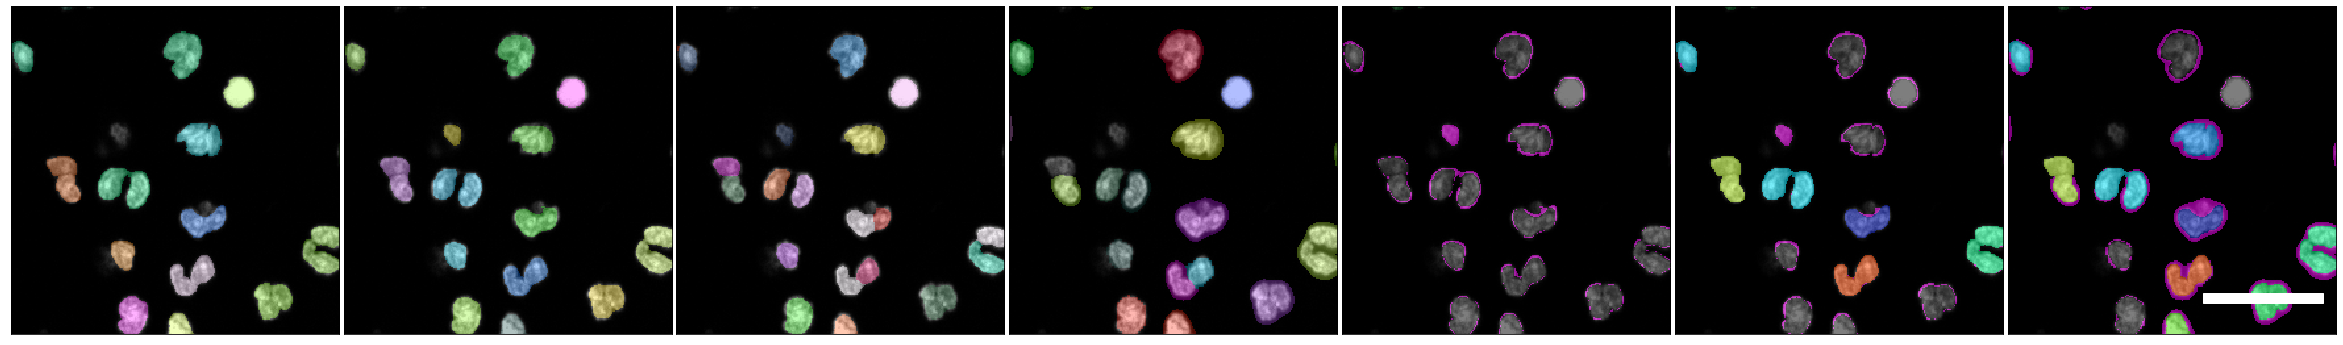

In [106]:
arg_dic = {}
img_dir = "."
exp_babe = "BABE_Biological"
fov_babe = "Plate1_E03_T0001FF001Zall.tif"
roi_babe = (500, 1000, 500, 1000)
mag_babe = int(20/0.216)

generate_error_visualization(exp_babe, fov_babe, roi_babe, mag_babe)


exp_laurent = "HiTIF_Laurent_Technical"
fov_laurent = "AUTO0496_J14_T0001F001L01A01Z01C01.tif"
roi_laurent = (500, 1000, 500, 1000)
mag_laurent = int(20/0.325)
generate_error_visualization(exp_laurent, fov_laurent, roi_laurent, mag_laurent)

exp_colorectal = "HiTIF_Colorectal_Biological"
fov_colorectal = "AUTO0218_N07_T0001F004L01A01Z01C01.tif"
roi_colorectal = (750, 1000, 750, 1000)
mag_colorectal = int(20/0.65)
generate_error_visualization(exp_colorectal, fov_colorectal, roi_colorectal, mag_colorectal)

exp_manasi = "Manasi_Technical"
fov_manasi = "Plate1_M21_T0001F003L01A01Z01C01.tif"
roi_manasi = (750, 1000, 750, 1000)
mag_manasi = int(20/0.216)
generate_error_visualization(exp_manasi, fov_manasi, roi_manasi, mag_manasi)


In [10]:
def highlight_gt_difference(exp, fov,  dim, mag):
    gt_manual = os.path.join(img_dir, "GT-manual", exp, fov)
    gt_auto = os.path.join(img_dir, "GT", exp, fov)
    gray = os.path.join(img_dir, "GreyScale", exp, fov)
    gt_manual_img = skimage.io.imread(gt_manual)
    gt_auto_img = skimage.io.imread(gt_auto)
    gray_img = skimage.io.imread(gray)
    
    #Increase the contrast of the gray scale image
    v_min, v_max = np.percentile(gray_img, (0.2, 99.8))
    gray_contrast = exposure.rescale_intensity(gray_img, in_range=(v_min, v_max))
    
    gt_manual_per, gt_manual_xor = get_images(gt_manual_img,gt_manual_img)
    gt_auto_per, gt_auto_xor = get_images(gt_auto_img,gt_manual_img)
    
    nfigures = 3
    fig, axes = plt.subplots(1,nfigures, figsize=(32,32))
    fig.tight_layout(pad=-2.6)


    #nuclei_cmap = "nipy_spectral"
    #inf_alpha = 0.5
    #err_alpha = 0.3
    
    nuclei_cmap = "gist_ncar"
    inf_alpha = 0.7
    err_alpha = 0.5
    
    #convert zero to black color in gitst_ncar
    if nuclei_cmap == "gist_ncar":
        from matplotlib import cm
        from matplotlib.colors import ListedColormap
        gist_ncar = cm.get_cmap('gist_ncar', 256)
        newcolors = gist_ncar(np.linspace(0, 1, 256))
        black = np.array([0, 0, 0, 1])
        magneta = np.array([1, 0, 1, 1])
        newcolors[0, :] = black
        newcolors[255, :] = magneta
        newcmp = ListedColormap(newcolors)
        nuclei_cmap = newcmp
    
    
    axes_id = -1

    axes_id += 1
    axes[axes_id].imshow(gt_manual_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(gt_auto_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(gt_auto_xor[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)
    
    x_loc = int((dim[1] - dim[0]) * 3 / 4)
    y_loc = int((dim[3] - dim[2]) * 7 / 8)
    
    lower_write = dim[1] - dim[0] - 20 / (500 / (dim[1] - dim[0]))
    rect = patches.Rectangle((lower_write - mag, y_loc), mag, 8, color ='w')
    axes[axes_id].add_patch(rect)

    
    #Turn off axis and y axis
    for axes_id in range(0, nfigures):
        axes[axes_id].get_xaxis().set_visible(False)
        axes[axes_id].get_yaxis().set_visible(False)

    figure_name = "{0}_{1}_gt_comparison.tif".format(exp, fov.replace(".tif", ""))
    fig.savefig(figure_name, bbox_inches = 'tight',pad_inches = 0)
    
    

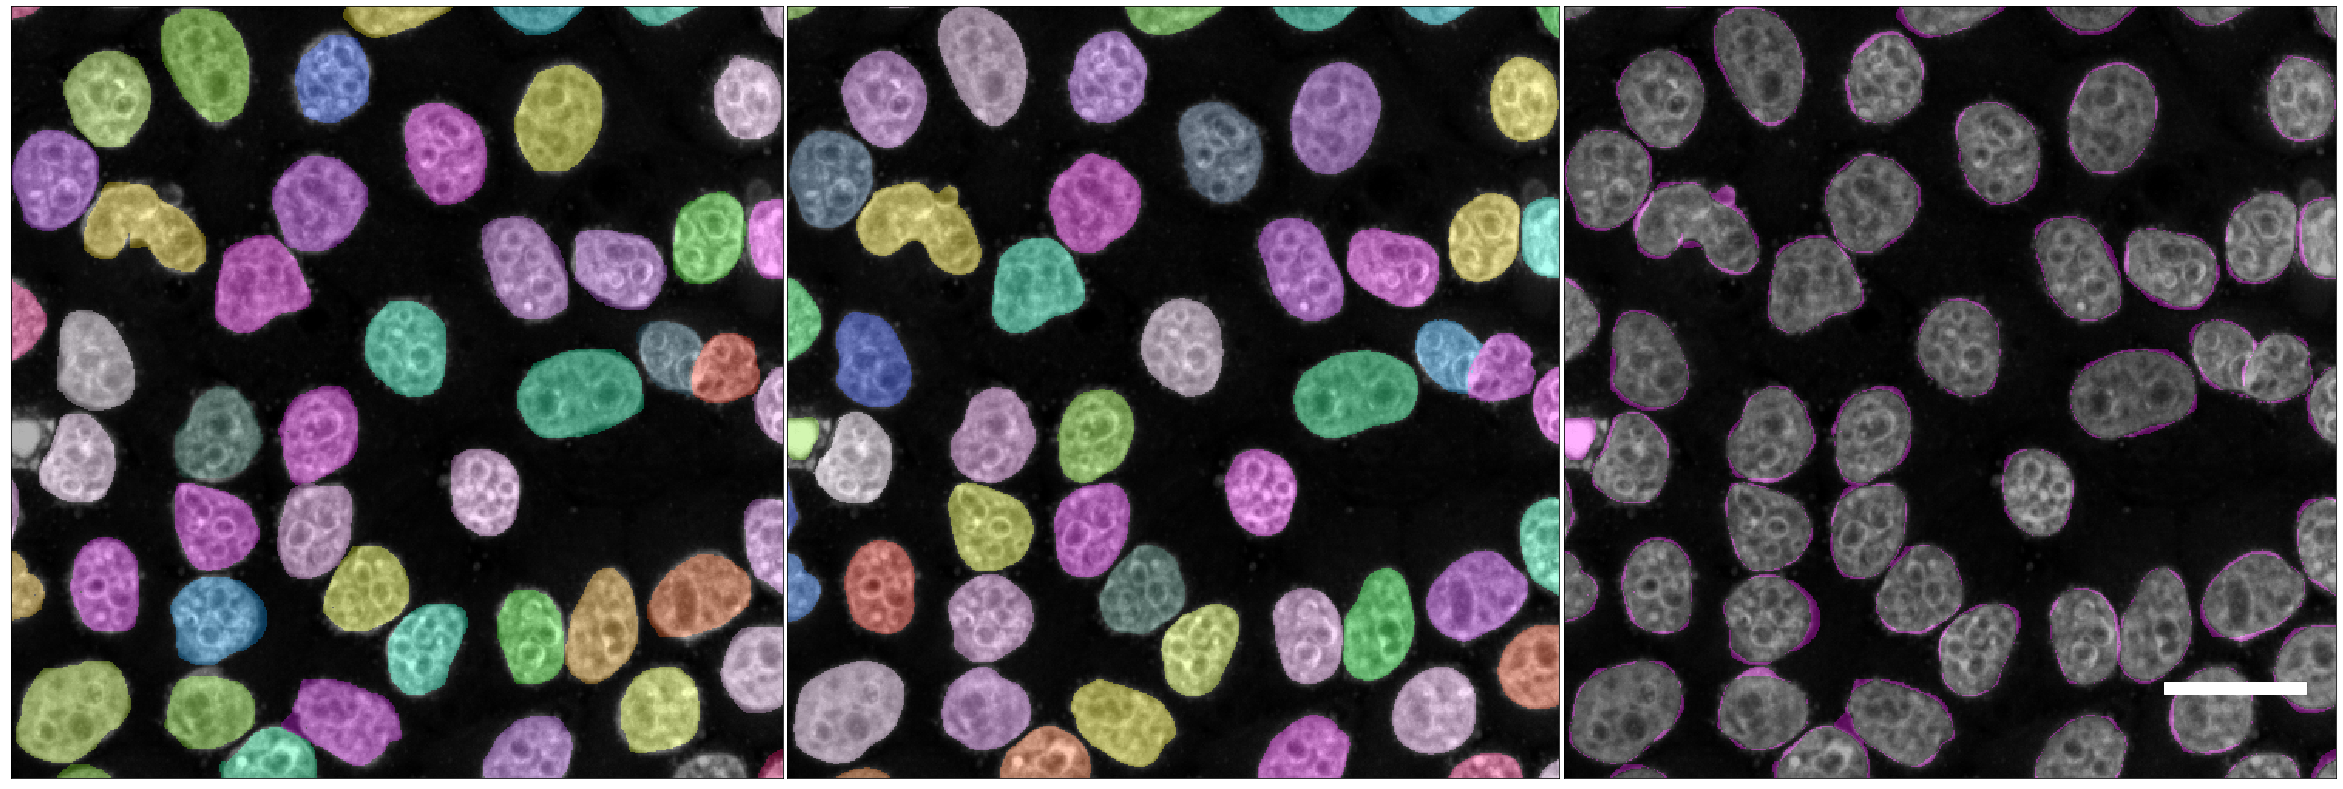

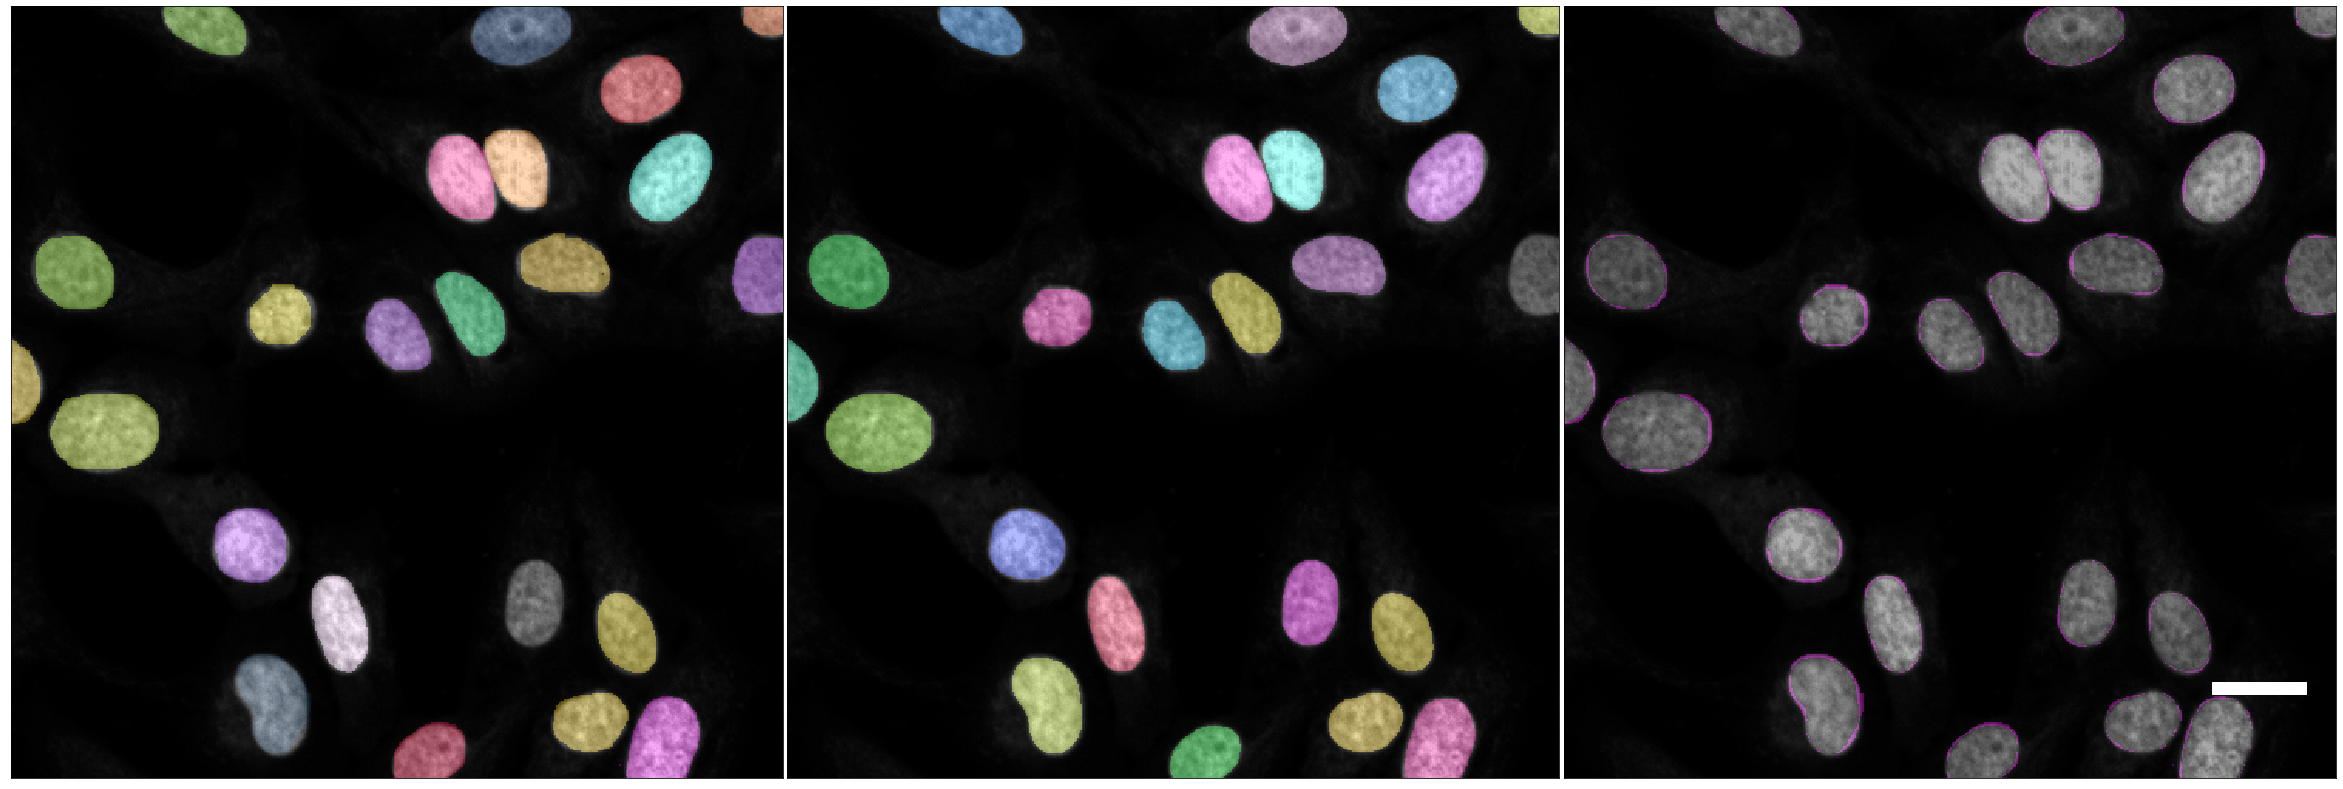

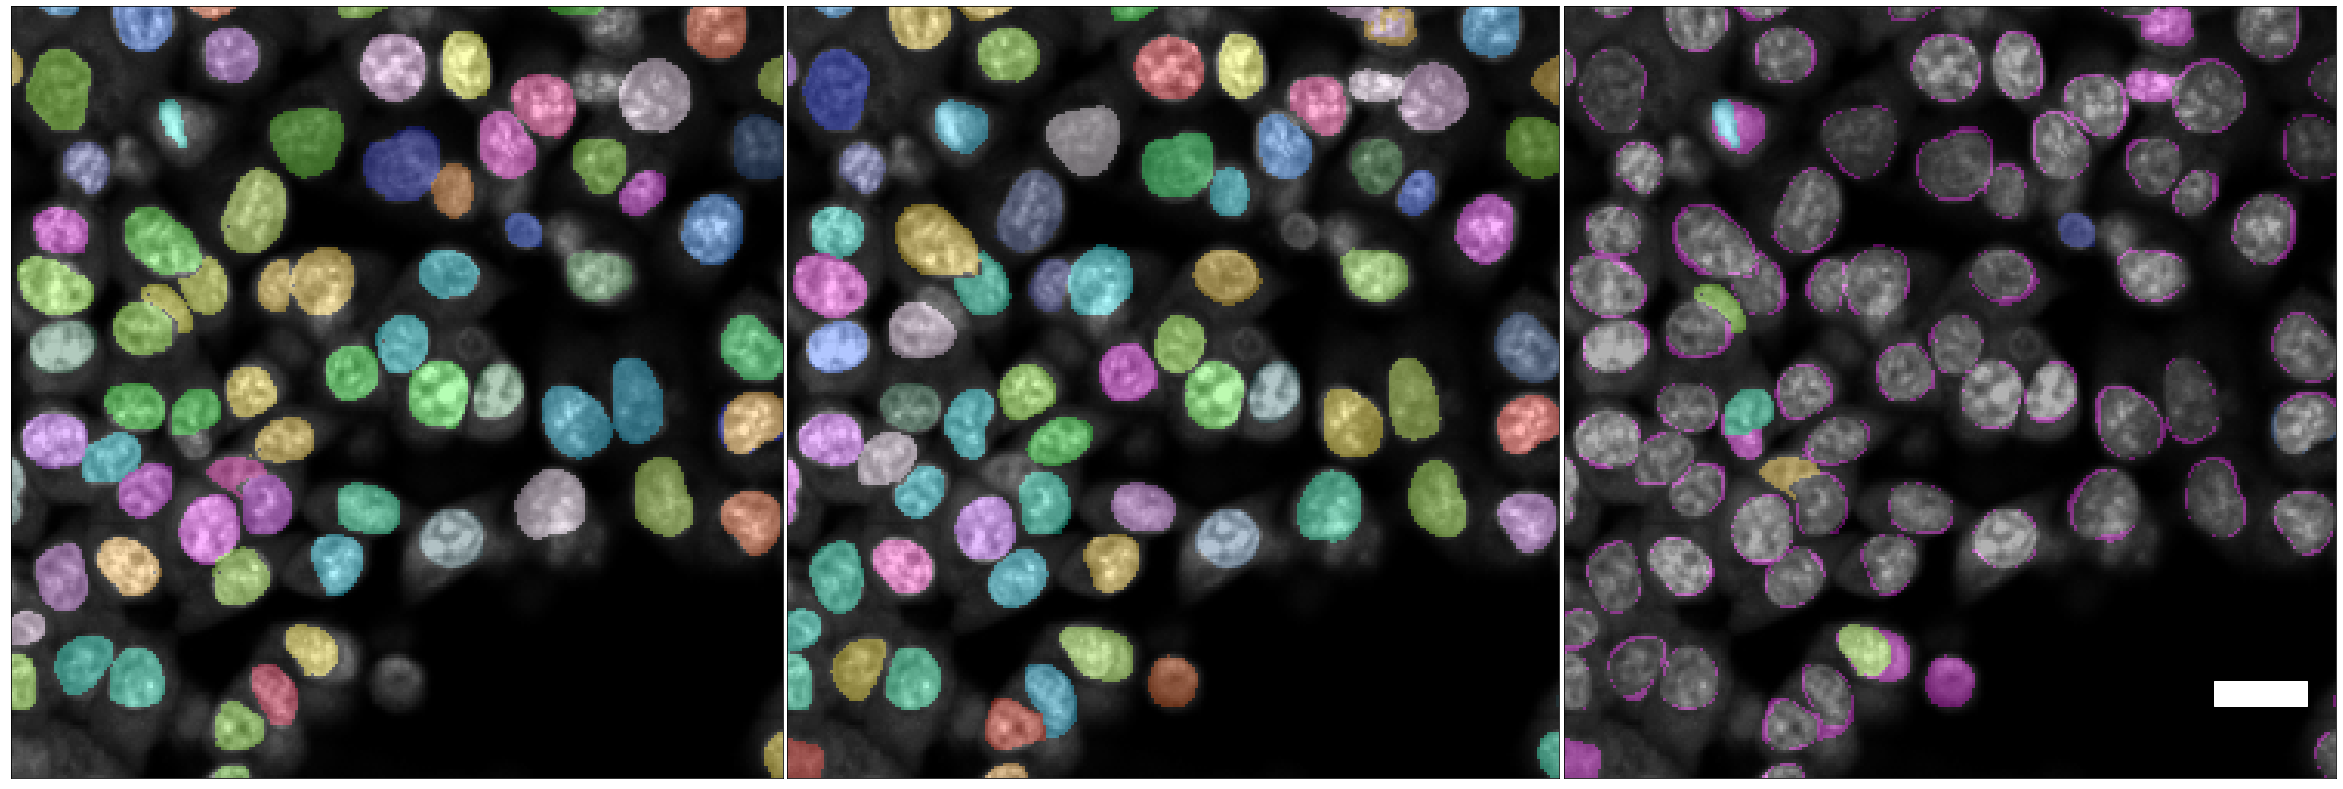

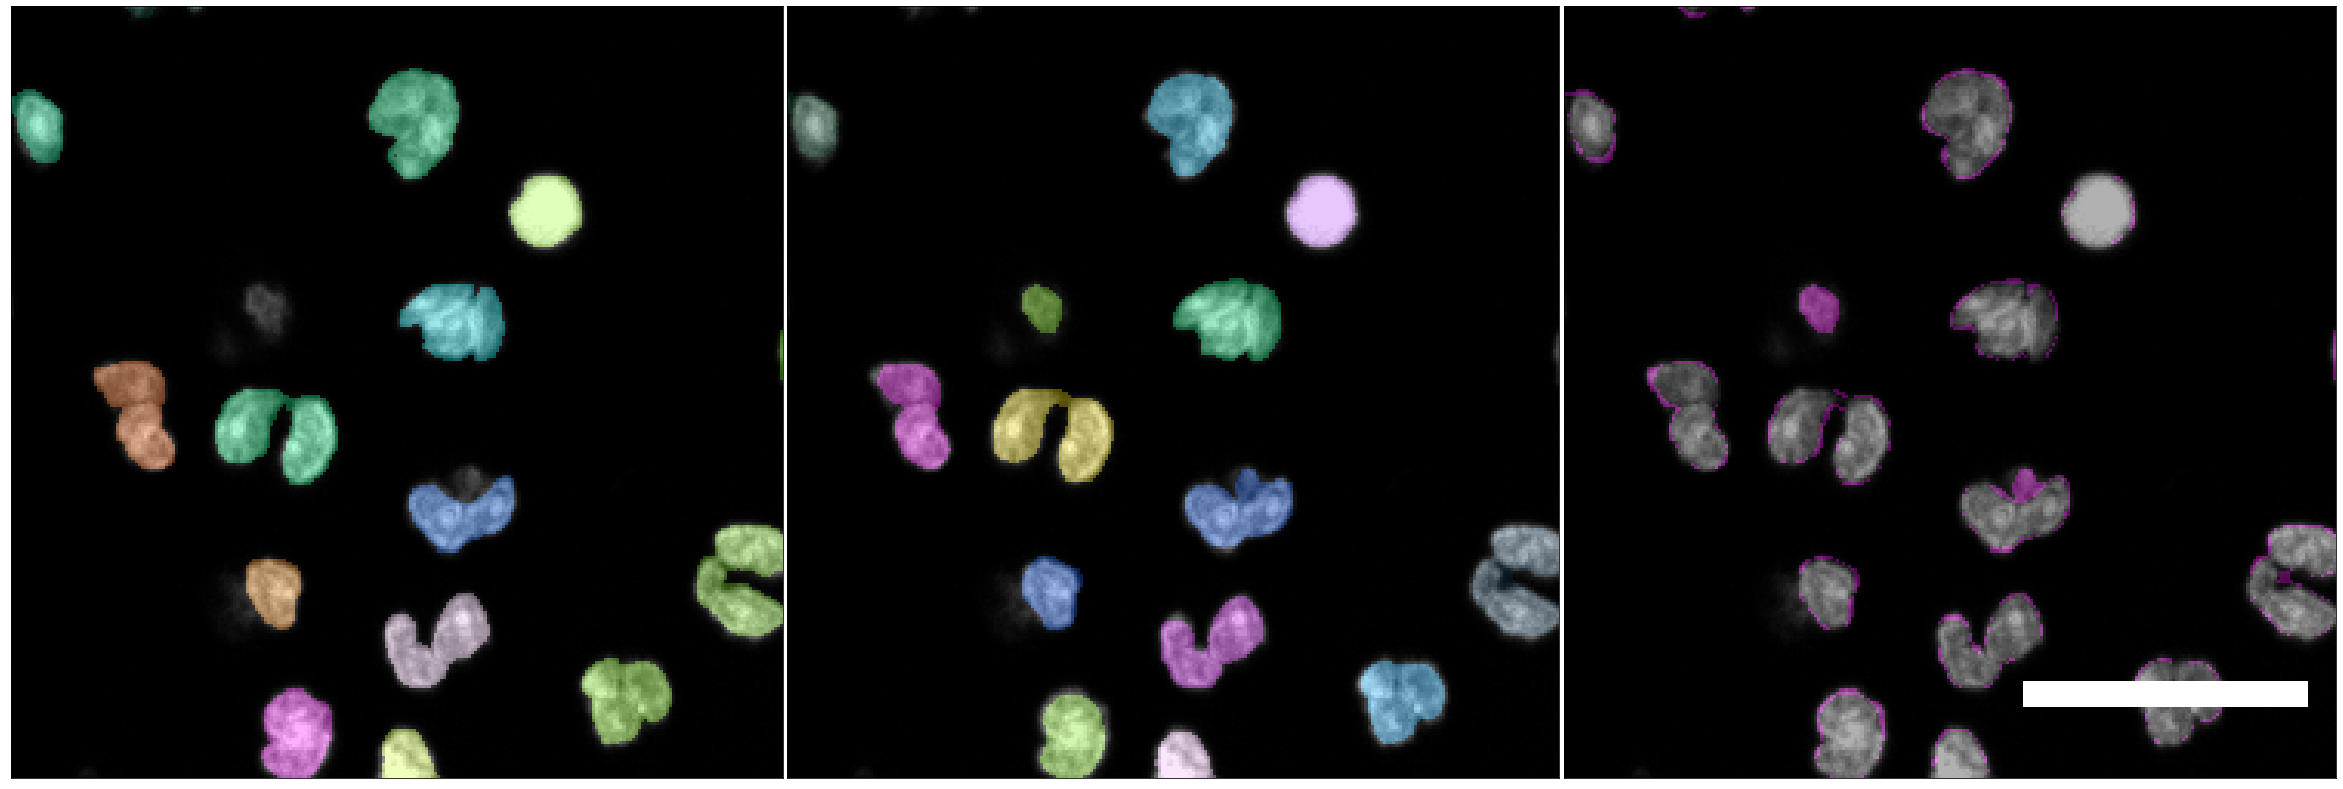

In [11]:
arg_dic = {}
img_dir = "."
exp_babe = "BABE_Biological"
fov_babe = "Plate1_E03_T0001FF001Zall.tif"
roi_babe = (500, 1000, 500, 1000)
mag_babe = int(20/0.216)

highlight_gt_difference(exp_babe, fov_babe, roi_babe, mag_babe)


exp_laurent = "HiTIF_Laurent_Technical"
fov_laurent = "AUTO0496_J14_T0001F001L01A01Z01C01.tif"
roi_laurent = (500, 1000, 500, 1000)
mag_laurent = int(20/0.325)
highlight_gt_difference(exp_laurent, fov_laurent, roi_laurent, mag_laurent)

exp_colorectal = "HiTIF_Colorectal_Biological"
fov_colorectal = "AUTO0218_N07_T0001F004L01A01Z01C01.tif"
roi_colorectal = (750, 1000, 750, 1000)
mag_colorectal = int(20/0.65)
highlight_gt_difference(exp_colorectal, fov_colorectal, roi_colorectal, mag_colorectal)

exp_manasi = "Manasi_Technical"
fov_manasi = "Plate1_M21_T0001F003L01A01Z01C01.tif"
roi_manasi = (750, 1000, 750, 1000)
mag_manasi = int(20/0.216)
highlight_gt_difference(exp_manasi, fov_manasi, roi_manasi, mag_manasi)



In [52]:
def add_point(fov, start, size, point_id):
    fov[start[0]:start[0] + size[0], start[1]:start[1] +size[1]] = point_id

In [100]:
test_inf = np.zeros((100,100))
add_point(test_inf, (0,0), (20,10), 1)
add_point(test_inf, (20,20), (10,5), 2)
add_point(test_inf, (20, 25), (10, 5), 3)
add_point(test_inf, (20, 60), (10, 10), 4)
add_point(test_inf, (70,10), (10,10), 5) 

In [101]:
test_gt = np.zeros((100,100))
add_point(test_gt, (0,0), (10,10), 1)
add_point(test_gt, (20,20), (10,10), 2)
add_point(test_gt, (10,0), (10,10), 3)
add_point(test_gt, (20,60), (10,10), 4)
add_point(test_gt, (80,80), (10,10),5)
add_point(test_gt, (90,80), (10,10),6)

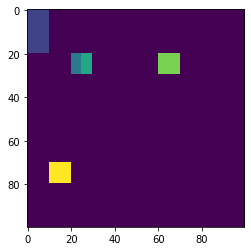

In [102]:
plt.imshow(test_inf)

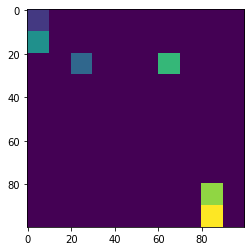

In [103]:
plt.imshow(test_gt)

In [104]:
iou = get_iou (test_inf, test_gt)

ground truth nuclei: 6
Inference nuclei: 5


In [105]:
precision_at(0.7, iou)

merges:1, splits:1, false_positives:4, false_negative:5


(array([False, False, False,  True, False, False]),
 array([ True,  True,  True, False,  True]),
 array([ True,  True,  True, False,  True,  True]))